# Fibonacci Strategies

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Fibonacci import Fibonacci , PrepareData
from util.Save_result_return import save_to_csv


## Get Data

In [3]:
XAUUSD = load_data()

In [ ]:
XAUUSD['D1'].info()

## Define Strategy

In [4]:
strategy = Fibonacci

In [5]:
account_size = 10000

## Prepare Data

In [6]:
data_D1 = PrepareData(XAUUSD['D1'])
data_H4 = PrepareData(XAUUSD['H4'])

In [ ]:
data_M30 = PrepareData(XAUUSD['M30'])
data_H1 = PrepareData(XAUUSD['H1'])

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(data_D1, strategy, cash=account_size, margin=1/100,  commission=0.0002 )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   16.299822
Equity Final [$]                          0.0
Equity Peak [$]                  13126.944848
Return [%]                             -100.0
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]           187290.058323
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -26.093805
Max. Drawdown Duration     5231 days 00:00:00
Avg. Drawdown Duration      590 days 00:00:00
# Trades                                   31
Win Rate [%]                              0.0
Best Trade [%]                       -3.16071
Worst Trade [%]                     -58.02992
Avg. Trade [%]                    

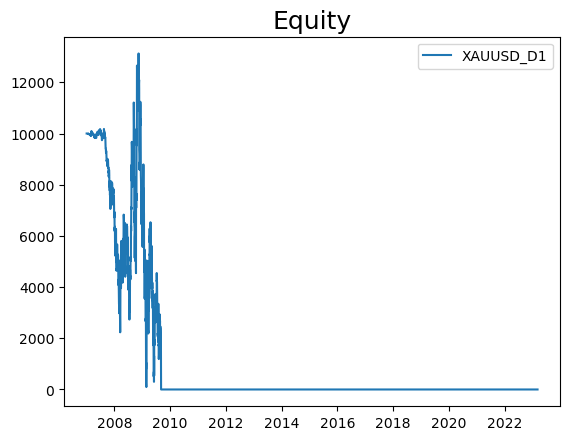

In [8]:
plot_equity_trades(result_D1['_equity_curve'],'XAUUSD_D1' , account_size)

### Save output

In [ ]:
save_to_csv(result_D1, '../../out/Technical_Strategy/Fibonacci/Backtest/result_D1.csv')  

## TF H4

In [9]:
Backtest_H4 = Backtest(data_H4, strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    5.097013
Equity Final [$]                          0.0
Equity Peak [$]                  10881.982841
Return [%]                             -100.0
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]             1070.734251
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -10.889324
Max. Drawdown Duration     5735 days 12:00:00
Avg. Drawdown Duration      454 days 16:00:00
# Trades                                   48
Win Rate [%]                              0.0
Best Trade [%]                      -2.012713
Worst Trade [%]                    -27.766322
Avg. Trade [%]                    

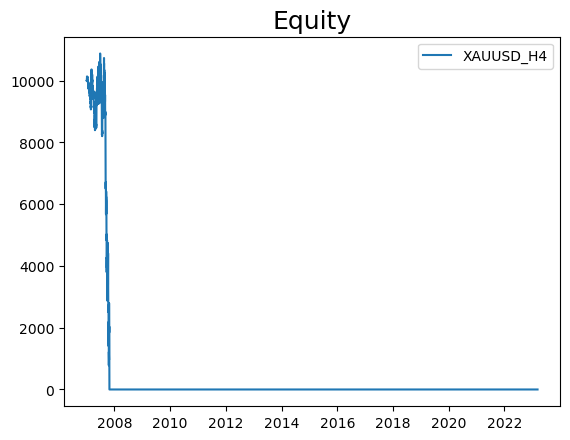

In [10]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4' , account_size)

### Save output

In [ ]:
save_to_csv(result_H4, '../../out/Technical_Strategy/Fibonacci/Backtest/result_H4.csv')  

## TF H1

In [ ]:
Backtest_H1 = Backtest(data_H1, strategy,
                       cash= account_size, margin=1/100,  commission=0.0002 )
result_H1 = Backtest_H1.run()
result_H1

In [ ]:
plot_equity_trades(result_H1['_equity_curve'], 'XAUUSD_H1', account_size)

### Save output

In [ ]:
save_to_csv(result_H1, '../../out/Technical_Strategy/Fibonacci/Backtest/result_H1.csv')  

## TF M30 

In [ ]:
Backtest_M30 = Backtest(data_M30, strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M30 = Backtest_M30.run()
result_M30

In [ ]:
plot_equity_trades(result_M30['_equity_curve'], 'XAUUSD_M30', account_size)

### Save output

In [ ]:
save_to_csv(result_M30, '../../out/Technical_Strategy/Fibonacci/Backtest/result_M30.csv')  